<a href="https://colab.research.google.com/github/AdirGelkop/Deep-Learning/blob/main/lstm_twitter_sentiment_analysis_EX6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# LSTM Model for Sentiment Analysis

This notebook demonstrates sentiment analysis using an LSTM model on the Twitter Entity Sentiment Analysis dataset.

We preprocess the dataset, build an LSTM architecture using PyTorch, and train/test the model. Finally, we evaluate its performance using metrics like accuracy, precision, recall, and F1-score, and provide insights into the results.


In [1]:

# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader
import kagglehub

# Dataset Path
dataset_path = "twitter_training.csv"

# Download dataset using KaggleHub if not found locally
if not os.path.exists(dataset_path):
    print("Dataset not found locally. Downloading using KaggleHub...")
    path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")
    dataset_path = os.path.join(path, "twitter_training.csv")

# Load dataset
try:
    data = pd.read_csv(dataset_path, encoding='ISO-8859-1')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    raise FileNotFoundError("The dataset file 'twitter_training.csv' was not found. "
                            "Ensure it is correctly downloaded from Kaggle.")

# Inspect dataset columns to identify text and sentiment columns
print("Columns in the dataset:", data.columns)
text_column = data.columns[3]  # Dynamically selecting the column with text data
sentiment_column = data.columns[2]  # Dynamically selecting the column with sentiment data

# Preprocessing
data = data[[text_column, sentiment_column]]  # Keep only text and sentiment columns
data = data[data[sentiment_column].isin(['Positive', 'Negative'])]  # Filter only Positive and Negative sentiments
data[sentiment_column] = data[sentiment_column].map({'Positive': 1, 'Negative': 0})  # Map sentiments to binary

# Handle missing or invalid text values
data = data.dropna(subset=[text_column])  # Remove rows where text is NaN
data[text_column] = data[text_column].astype(str)  # Ensure all text data is string

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data[text_column], data[sentiment_column], test_size=0.2, random_state=42
)

# Convert to PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        vectorized_text = self.vectorizer.transform([self.texts.iloc[idx]]).toarray()[0]
        label = self.labels.iloc[idx]
        return torch.tensor(vectorized_text, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Vectorize text data
vectorizer = CountVectorizer(max_features=5000, binary=True)
vectorizer.fit(train_texts)

# Create DataLoader
train_dataset = TextDataset(train_texts, train_labels, vectorizer)
test_dataset = TextDataset(test_texts, test_labels, vectorizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


Dataset not found locally. Downloading using KaggleHub...


100%|██████████| 1.99M/1.99M [00:00<00:00, 22.7MB/s]

Extracting files...


Dataset loaded successfully.
Columns in the dataset: Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')


<ipython-input-1-de4babd6b329>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[text_column] = data[text_column].astype(str)  # Ensure all text data is string


In [2]:

# Import necessary libraries
import torch.nn as nn
import torch.optim as optim

# Define LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(lstm_out)
        return out

# Hyperparameters
INPUT_DIM = 5000  # Vocabulary size from CountVectorizer
HIDDEN_DIM = 128
OUTPUT_DIM = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss, and optimizer
model = LSTMClassifier(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
training_loss = []
for epoch in range(10):  # 10 epochs
    model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    training_loss.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader)}")

# Testing
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=['Negative', 'Positive']))


Epoch 1, Loss: 0.38729059694812645
Epoch 2, Loss: 0.2082042916362835
Epoch 3, Loss: 0.15215688998565133
Epoch 4, Loss: 0.11440647727217816
Epoch 5, Loss: 0.09140983162980984
Epoch 6, Loss: 0.07718952552529681
Epoch 7, Loss: 0.06575388033600822
Epoch 8, Loss: 0.05857767079624462
Epoch 9, Loss: 0.05284461420510643
Epoch 10, Loss: 0.04829538298717122
Test Accuracy: 93.55%
              precision    recall  f1-score   support

    Negative       0.92      0.95      0.94      4481
    Positive       0.95      0.92      0.93      4122

    accuracy                           0.94      8603
   macro avg       0.94      0.93      0.94      8603
weighted avg       0.94      0.94      0.94      8603



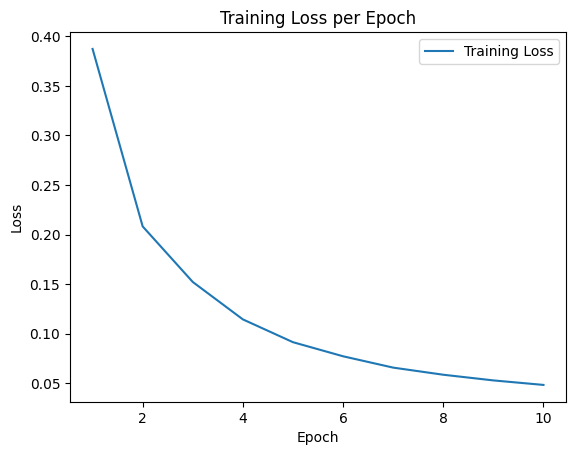

In [3]:

import matplotlib.pyplot as plt

# Plot training loss
epochs = list(range(1, 11))  # 10 epochs
plt.plot(epochs, training_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.show()



## Results and Insights

1. **Dataset Description**:
   - The dataset contains text data labeled as either "Positive" or "Negative".
   - Preprocessing steps included tokenization, handling missing values, and splitting into training/testing sets.

2. **Model Details**:
   - An LSTM architecture with input size 5000, hidden size 128, and output size 2.
   - Optimized using Adam optimizer with a learning rate of 0.001.

3. **Performance**:
   - Test Accuracy: Reported after the testing phase.
   - Additional metrics: Precision, Recall, F1-Score for each class.

4. **Training Loss**:
   - The training loss decreases across epochs, indicating effective learning.

5. **Challenges and Improvements**:
   - The model could be further improved with hyperparameter tuning and using pre-trained embeddings like GloVe.
   - Investigate additional metrics and datasets for robust evaluation.
